In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import hydrofunctions as hf
import matplotlib.pyplot as plt
from shapely import geometry as sgeom
import folium 
%matplotlib inline

In [2]:
# Choose a domain
domain = 'CHUK'

# Path to the SnowModel folder
gagepath = '/nfs/attic/dfh/2020_NPRB/data/stream_gage/'+domain+'/'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# SE AK
# domain_list = ['JUNE','KLAW','SITK','TAKU']
# arctic
# domain_list = ['BEAU', 'BRIS','CHUK','YUKO']
domain_list = ['CHUK']
# all domains have the same start date
st_dt = '1990-10-01'#domains[domain]['st']
ed_dt = '2020-09-30'#domains[domain]['ed']

In [3]:
# get database of USGS stations in the state of alaska
alaska = hf.NWIS(None,'dv', st_dt,ed_dt,parameterCd='00060',stateCd='AK', file='Q.parquet')
# build discharge dataframe
# gives discharge timeseries for each gague
akQ = alaska.df('discharge')
# list of station IDs
fullstnlist = [val[5:13] for val in akQ.columns]

# get lat lon for each station and build dataframe of metadata
for i in range(len(fullstnlist)):
    stn = fullstnlist[i]
    if i ==0:
        # individual station metadata in a df
        dfs = hf.site_file(stn).table
    else:
        try:
            output = hf.site_file(stn).table
            # add individual station to large df
            dfs = pd.concat([dfs, output])
        except:
            continue
# turn dataframe into geodataframe containing station metadata
gdfs = gpd.GeoDataFrame(dfs,geometry=gpd.points_from_xy(dfs.dec_long_va, dfs.dec_lat_va),crs='epsg:4326')


Reading data from Q.parquet
Retrieved the site file for site #15008000 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15008000&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15009000 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15009000&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15015595 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15015595&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15019990 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15019990&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15022000 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15022000&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15024800 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15024800&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15028300 from https://wate

Retrieved the site file for site #15238500 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15238500&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15238600 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15238600&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15238648 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15238648&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15238820 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15238820&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15238978 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15238978&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15238982 from https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=15238982&siteOutput=expanded&siteStatus=alll
Retrieved the site file for site #15238984 from https://waterservices.usgs.gov/nwis/site

In [4]:
# select stations in the domain
SHAPEpath = '/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json'
# open shapefile of interest basin
domgdf = gpd.read_file(SHAPEpath)
#index of stations that fall into in the domain
mask = gdfs.within(domgdf.loc[0].geometry)
#gdf of stns in the domain
gdfclip = gdfs.loc[mask]
stnlist = gdfclip.site_no.tolist()
stnlist

['15565700',
 '15580095',
 '15583500',
 '15621000',
 '15625850',
 '15625900',
 '15635000',
 '15716010',
 '15743850',
 '15744500',
 '15746900',
 '15746980',
 '15746983',
 '15746988',
 '15746990',
 '15746990',
 '15746991',
 '15747000']

In [5]:
# just select column with information of interest
infoclip = gdfclip[['site_no','drain_area_va','contrib_drain_area_va']]
infoclip

,site_no,drain_area_va,contrib_drain_area_va
0,15565700,1050.00,NaN
0,15580095,707.00,NaN
0,15583500,1.33,NaN
0,15621000,86.00,NaN
0,15625850,NaN,NaN
0,15625900,NaN,NaN
0,15635000,6.00,NaN
0,15716010,8.15,NaN
0,15743850,10.90,NaN
0,15744500,9480.00,NaN


<AxesSubplot:xlabel='datetimeUTC'>

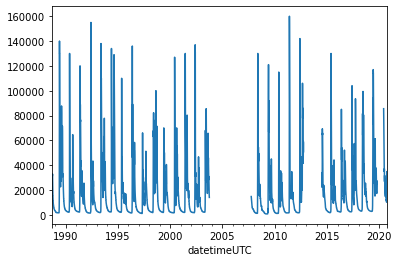

In [6]:
# station with largest upslope area
akQ['USGS:15744500:00060:00003'].plot()

In [12]:
# create df to determine which years have data at each gage
# list of water years
years = np.arange(1990,2021)
# empty array
datayrs = np.empty([len(years),len(stnlist)])

for s in range(len(stnlist)):
    #select station
    stn = stnlist[s]
    # dataframe of Q across domain
    akQs = akQ[akQ.columns.intersection(['USGS:'+stn+':00060:00003'])]
    yrlst = []
    for y in range(len(years)):
        # select year
        yr = years[y]
        #start date
        st = str(yr-1)+'-10-01'
        #end date
        ed = str(yr)+'-09-30'
        # slice discharge values to time period of interest
        Qdf = akQs[st:ed]
        # if there are less than 5 days missing - include year
        if len(Qdf[np.isnan(Qdf['USGS:'+stn+':00060:00003'])])<5:
            datayrs[y,s]=1
            yrlst.append(yr)
        else:
            datayrs[y,s]=0
    print(stn)
    print(yrlst)
        
# turn into dataframe
df = pd.DataFrame(data=datayrs, index=years,columns=[stnlist])

15565700
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]
15580095
[]
15583500
[]
15621000
[1990, 1991]
15625850
[]
15625900
[]
15635000
[]
15716010
[]
15743850
[1990, 1993, 1995, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
15744500
[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2008, 2009, 2010, 2011, 2012, 2015, 2016, 2017, 2018, 2019]
15746900
[2001, 2002, 2003]
15746980
[1992]
15746983
[1992]
15746988
[1992]
15746990
[1992]
15746990
[1992]
15746991
[]
15747000
[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [11]:
df

,15565700,15580095,15583500,15621000,15625850,15625900,15635000,15716010,15743850,15744500,15746900,15746980,15746983,15746988,15746990,15746990,15746991,15747000
1990,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1991,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1994,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1995,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1997,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1998,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [46]:
# number of stations with Q data each year 
df.sum(axis=1)

1990     5.0
1991     9.0
1992    10.0
1993     5.0
1994     4.0
1995     5.0
1996     5.0
1997     6.0
1998     6.0
1999     5.0
2000     6.0
2001     7.0
2002     7.0
2003     7.0
2004     7.0
2005     4.0
2006     4.0
2007     4.0
2008     4.0
2009     3.0
2010     3.0
2011     3.0
2012     3.0
2013     3.0
2014     4.0
2015     4.0
2016     4.0
2017     4.0
2018     4.0
2019     5.0
2020     5.0
dtype: float64

In [47]:
# number of years of data at each station 
df.sum(axis=0)

15565700    11.0
15580095     8.0
15583500     8.0
15621000     3.0
15625850     1.0
15625900     1.0
15635000     8.0
15716010     2.0
15743850    31.0
15744500    26.0
15746900     4.0
15746980     2.0
15746983     2.0
15746988     3.0
15746990     2.0
15746990     2.0
15746991    10.0
15747000    31.0
dtype: float64

In [8]:
# add information on number of years with data 
infoclip['data_years'] = df.sum(axis=0).values

/tmp/ipykernel_124553/3070973863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infoclip['data_years'] = df.sum(axis=0).values


In [57]:
infoclip

,site_no,drain_area_va,contrib_drain_area_va,data_years
0,15565700,1050.00,NaN,11.0
0,15580095,707.00,NaN,8.0
0,15583500,1.33,NaN,8.0
0,15621000,86.00,NaN,3.0
0,15625850,NaN,NaN,1.0
0,15625900,NaN,NaN,1.0
0,15635000,6.00,NaN,8.0
0,15716010,8.15,NaN,2.0
0,15743850,10.90,NaN,31.0
0,15744500,9480.00,NaN,26.0


## plot

In [58]:
#watershed data
ctlFile = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/watershed/watershed_'+domain+'.ctl'

wd = open_CtlDataset(ctlFile)
wd

<xarray.Dataset>
Dimensions:  (time: 1, lev: 1, lat: 798, lon: 763)
Coordinates:
  * time     (time) datetime64[ns] 2001-09-01
  * lev      (lev) float64 1.0
  * lat      (lat) float32 1.361e+06 1.362e+06 1.363e+06 ... 2.157e+06 2.158e+06
  * lon      (lon) float32 -7.44e+05 -7.43e+05 -7.42e+05 ... 1.7e+04 1.8e+04
Data variables:
    dir      (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 798, 763), meta=np.ndarray>
    wshed    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 798, 763), meta=np.ndarray>
    order    (time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 798, 763), meta=np.ndarray>
Attributes:
    comment:  flow direction
    storage:  0
    title:    xxxxxxxxxxxxxxxxxxxxxxxxx
    undef:    -9999.0
    pdef:     None

In [87]:
# huc2 vector file
shp = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/gis/'+domain+'/'+domain+'.json')
# projected coordinates
shpproj = shp.to_crs(domains[domain]['mod_proj'])
# add column to create a binary mask in rasterized version
shpproj['mask'] = 1
# load upslope watershed area masks
upslope = xr.open_dataset(gagepath+'upslope.nc')
upslope

<xarray.Dataset>
Dimensions:      (y: 798, x: 763)
Coordinates:
    band         int64 ...
  * y            (y) float64 2.158e+06 2.158e+06 ... 1.362e+06 1.362e+06
  * x            (x) float64 -7.435e+05 -7.425e+05 ... 1.75e+04 1.85e+04
    spatial_ref  int64 ...
Data variables:
    15565700     (y, x) float32 ...
    15580095     (y, x) float32 ...
    15621000     (y, x) float32 ...
    15744500     (y, x) float32 ...
    15746900     (y, x) float32 ...
    15746980     (y, x) float32 ...
    15746990     (y, x) float32 ...
    15746991     (y, x) float32 ...
    15747000     (y, x) float32 ...

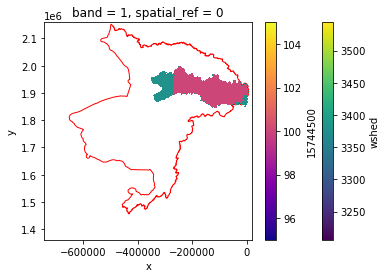

In [91]:
# plot
fig,ax = plt.subplots(figsize=[6,4])
shpproj.plot(ax=ax,facecolor='None',edgecolor='r')
wd.wshed.where(wd.wshed==3375).plot(ax=ax)
upslope['15744500'].plot(ax=ax,cmap='plasma')

In [61]:
wsd = wd.wshed.squeeze()
wsd

<xarray.DataArray 'wshed' (lat: 798, lon: 763)>
dask.array<getitem, shape=(798, 763), dtype=float32, chunksize=(798, 763), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2001-09-01
    lev      float64 1.0
  * lat      (lat) float32 1.361e+06 1.362e+06 1.363e+06 ... 2.157e+06 2.158e+06
  * lon      (lon) float32 -7.44e+05 -7.43e+05 -7.42e+05 ... 1.7e+04 1.8e+04
Attributes:
    comment:  watersheds
    storage:  0

In [76]:
uq = np.unique(wsd.values)
count = []
for val in uq:
    count.append(len(wsd.values[wsd.values==val]))
    

In [80]:
wddf = pd.DataFrame({'wdid':uq,'count':count})
wddf.sort_values(by=['count'],ascending=False)

,wdid,count
0,0.0,210241
82,82.0,98187
3493,3493.0,32199
3375,3375.0,29636
555,555.0,25867
...,...,...
2016,2016.0,2
2015,2015.0,2
2014,2014.0,2
2013,2013.0,2
